# Investigating well position effect: Scenario 4 (MAPK, LPAR1, Batch 6, separated morphology feature sets)
**Author:** Jessica Ewald <br>

Here we train on three plates and test on the fourth, all from the same batch. 

These results are for only one example: train on "2023-12-15_B4A3R1_P1T2", "2023-12-18_B4A3R1_P1T3", "2023-12-15_B4A3R1_P1T1", test on "2023-12-18_B4A3R1_P1T4". These plates are from batch 4. This scenario is most similar to our real analysis strategy. This version of scenario 4 compares different controls (MAPK and LPAR1) because the ALK WT and VAR both suffered from low cell viability. The protein channel here is therefore an even easier task. 

A previous iteration of this scenario found that both the protein and brightfield features behaved as expected: the randomly shuffled null is symmetrically distributed around 0.5, the REF-REF and VAR-VAR are slightly to the right of the random null (indicating that there is some position effect), and the REF-VAR are sometimes substantially to the right of the various control distributions and sometimes only slightly so. This makes sense because these cases represents strong and subtle phenotypes respectively. The non-protein features did not follow this pattern at all. For the more subtle ALK pair of phenotypes, there was an almost uniform distribution from 0 to 1 (F1 score) and no discernible difference between REF-VAR and REF-REF,VAR-VAR. For MAPK9-LPAR1, there are more high F1 scores for REF-VAR, but there are still REF-REF and VAR-VAR F1 scores ranging from 0 to 1. Our hypothesis is that the classifier can very efficiently learn well postion effect when there are multiple fluorescent channels and that something about the relative differences between the fluorescent channels is unique for each pair of wells. Here, we test that hypothesis by splitting up the non-protein features into 'DNA', 'AGP', and 'Mito' and training separate classifiers for each one. The 'GFP' protein features are retained as a positive control. 

In [1]:
# Imports
import pathlib
import polars as pl
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
result_dir = pathlib.Path(
    f"/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/Rep_Ctrls_scen4_B6_MAPK_LPAR1_sep_morph_06May2024"
)
batch = "Rep_Ctrls_scen4"
feature_sets = ["protein", "dna", "agp", "mito"]

In [3]:
# Read in all F1 score and plot
comparisons = [
    "REF_control_f1score",
    "VAR_control_f1score",
    "NULL_control_f1score",
    "f1score",
]
comp_dict = {
    "REF_control_f1score": "REF_REF",
    "VAR_control_f1score": "VAR_VAR",
    "NULL_control_f1score": "NULL",
    "f1score": "REF_VAR",
}

f1_score = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:

        df = pl.read_csv(
            f"{result_dir}/Rep_Ctrls_scen4_{fs}_{comp}_normalized_feature_selected.csv"
        )

        if "Reference_Well" in df.columns:
            df = df.rename(
                {"Reference_Well": "Well_One", "Variant_Well": "Well_Two"}
            )

        df = df.melt(id_vars=["Well_One", "Well_Two"]).with_columns(
            pl.lit(fs).alias("Feature_Set"),
            pl.lit(comp_dict[comp]).alias("Comparison"),
            pl.lit(batch).alias("Batch"),
        )
        f1_score = pl.concat([f1_score, df], how="vertical")

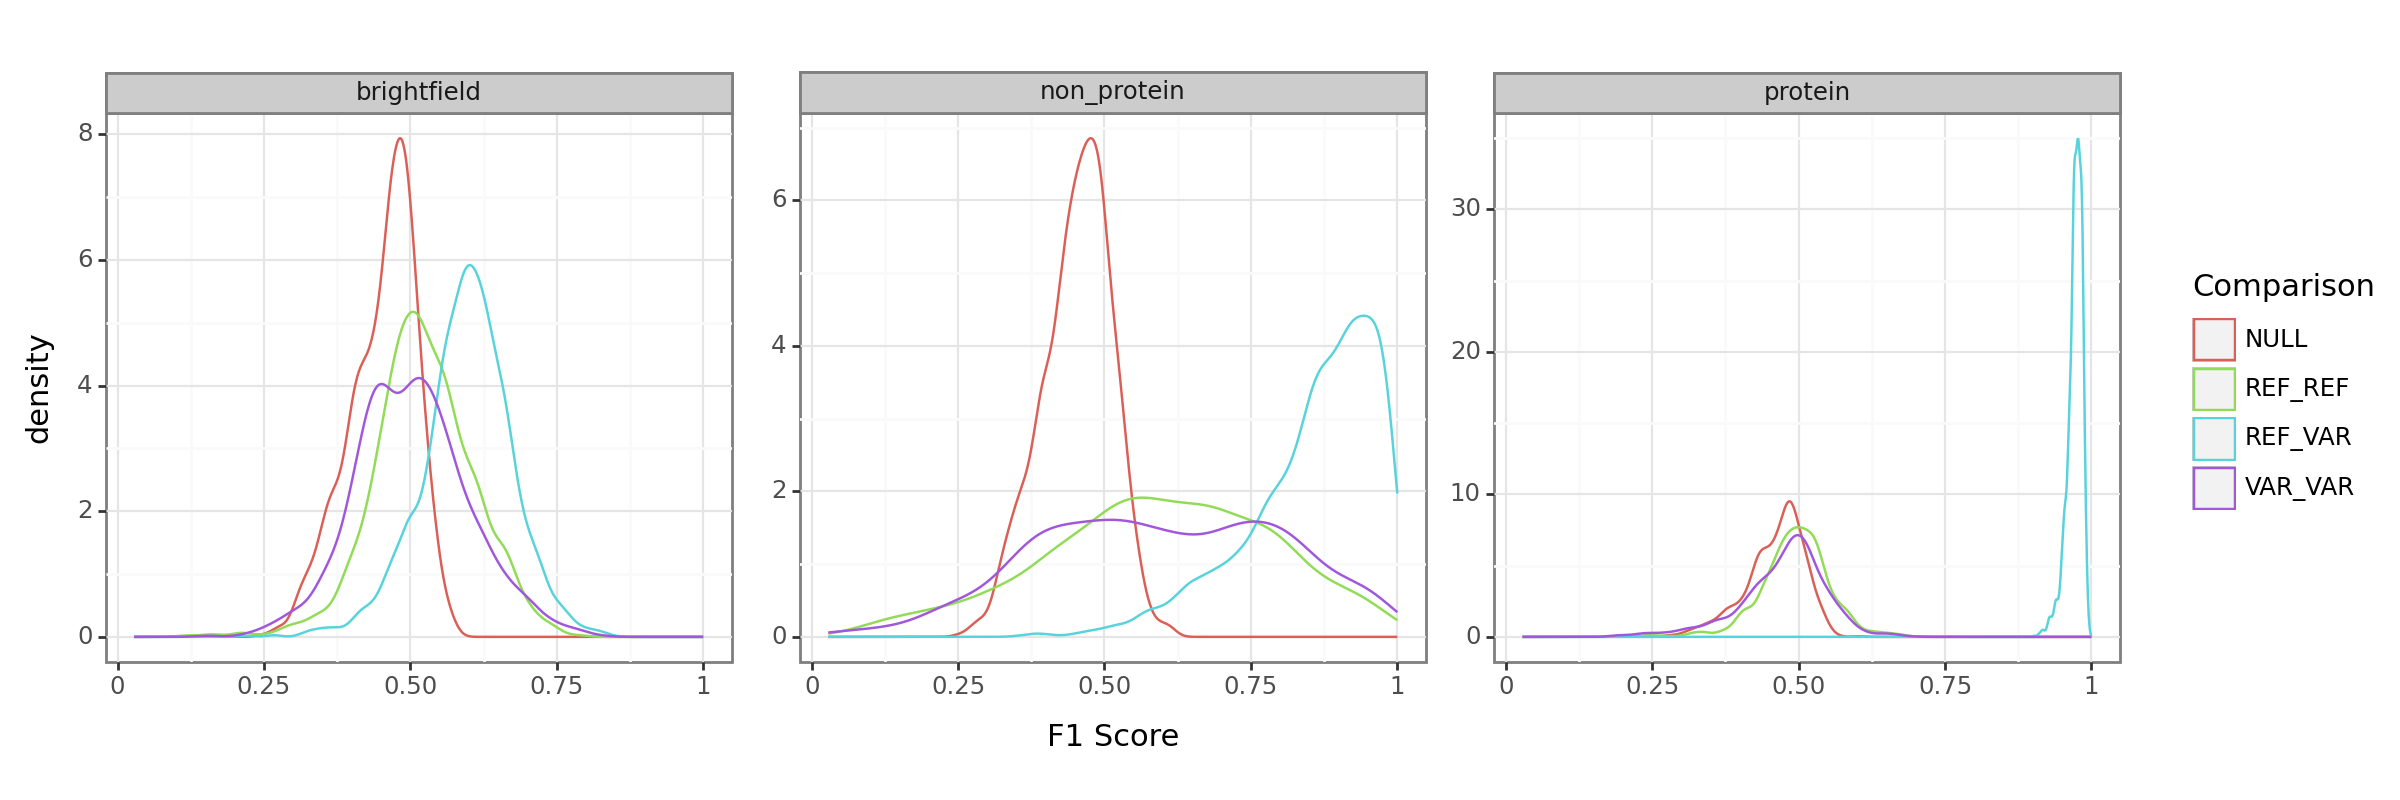

In [6]:
# try histograms with ggplot
import plotnine as pn
from plotnine import ggplot, aes, geom_density, theme_bw, xlab, facet_wrap, theme

pn.options.figure_size = (12,4)

plot1 = (ggplot(f1_score.filter(pl.col("variable") == "F1_Score").to_pandas()) 
+ aes(x = "value", color="Comparison")
+ facet_wrap("Feature_Set", scales='free_y')
+ geom_density()
+ theme_bw()
+ xlab("F1 Score"))

print(plot1)

In [4]:
# Read in all variable feature importance scores

comparisons = [
    "REF_control_feat_importance",
    "VAR_control_feat_importance",
    "NULL_control_feat_importance",
    "feat_importance",
]
comp_dict = {
    "REF_control_feat_importance": "REF_REF",
    "VAR_control_feat_importance": "VAR_VAR",
    "NULL_control_feat_importance": "NULL",
    "feat_importance": "REF_VAR",
}

feat_imp = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:

        df = pl.read_csv(
            f"{result_dir}/Rep_Ctrls_scen4_{fs}_{comp}_normalized_feature_selected.csv"
        )

        if "Reference_Well" in df.columns:
            df = df.rename(
                {"Reference_Well": "Well_One", "Variant_Well": "Well_Two"}
            )

        df = df.melt(id_vars=["Well_One", "Well_Two"]).with_columns(
            pl.lit(fs).alias("Feature_Set"),
            pl.lit(comp_dict[comp]).alias("Comparison"),
            pl.lit(batch).alias("Batch"),
        )
        feat_imp = pl.concat([feat_imp, df], how="vertical")

In [5]:
# Add unique identifier
feat_imp = feat_imp.with_columns(
    pl.concat_str(
        [
            pl.col("Well_One"),
            pl.col("Well_Two"),
            pl.col("Feature_Set"),
            pl.col("Comparison"),
        ],
        separator="_",
    ).alias("ClassifierID")
)

# Add rank of feature within each classifier
feat_imp = feat_imp.with_columns(
    pl.col("value")
    .rank(descending=True)
    .over("ClassifierID")
    .alias("FIP_rank")
)

In [6]:
# summarize ranks
imp_summary = feat_imp.group_by(["variable", "Feature_Set", "Comparison"]).agg(
    pl.col("FIP_rank").mean().alias("mean_VIP"),
    pl.col("value").mean().alias("mean_FIP")
)

plot_var = "mean_FIP"

protein_summary = imp_summary.filter(pl.col("Feature_Set") == "protein")
dna_summary = imp_summary.filter(pl.col("Feature_Set") == "dna")
agp_summary = imp_summary.filter(pl.col("Feature_Set") == "agp")
mito_summary = imp_summary.filter(pl.col("Feature_Set") == "mito")

prot_summary = imp_summary.filter(pl.col("Feature_Set") == "protein").pivot(index="variable", columns="Comparison", values=plot_var)
dna_summary = imp_summary.filter(pl.col("Feature_Set") == "dna").pivot(index="variable", columns="Comparison", values=plot_var)
agp_summary = imp_summary.filter(pl.col("Feature_Set") == "agp").pivot(index="variable", columns="Comparison", values=plot_var)
mito_summary = imp_summary.filter(pl.col("Feature_Set") == "mito").pivot(index="variable", columns="Comparison", values=plot_var)

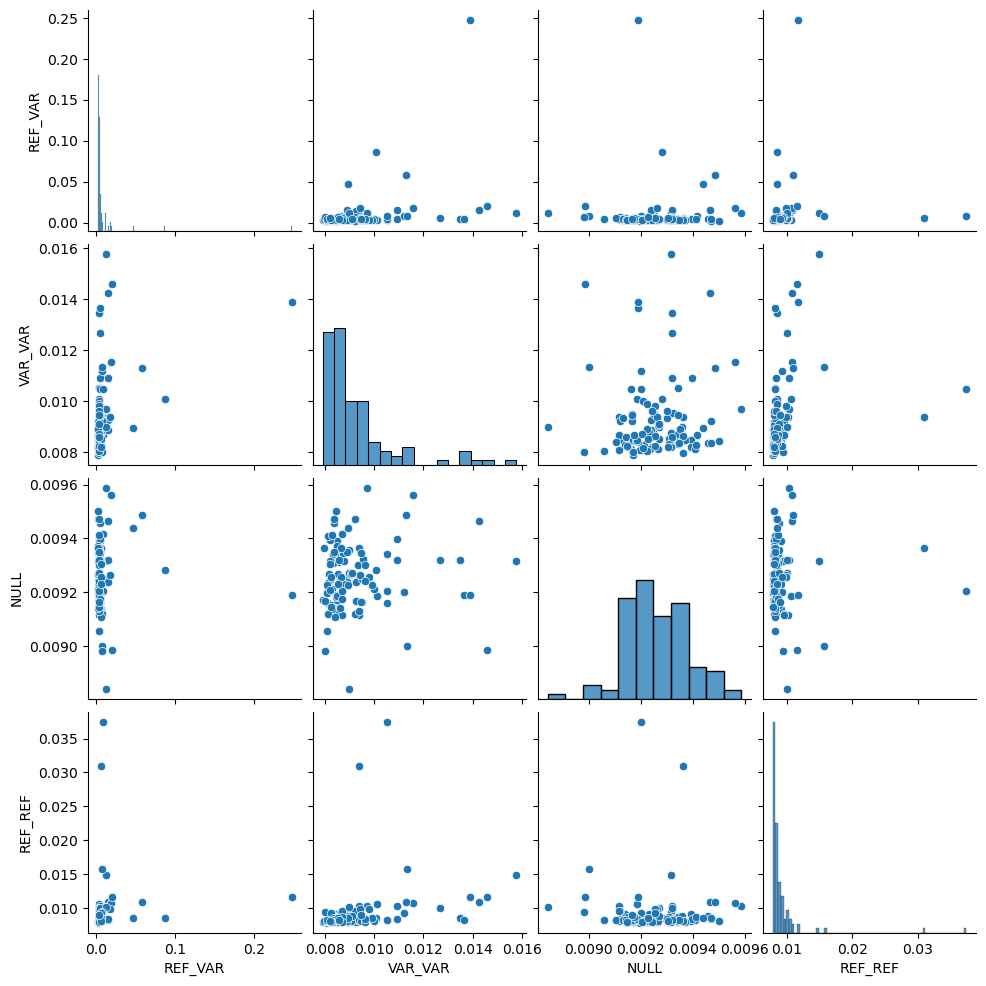

In [7]:
sns.pairplot(prot_summary.to_pandas())

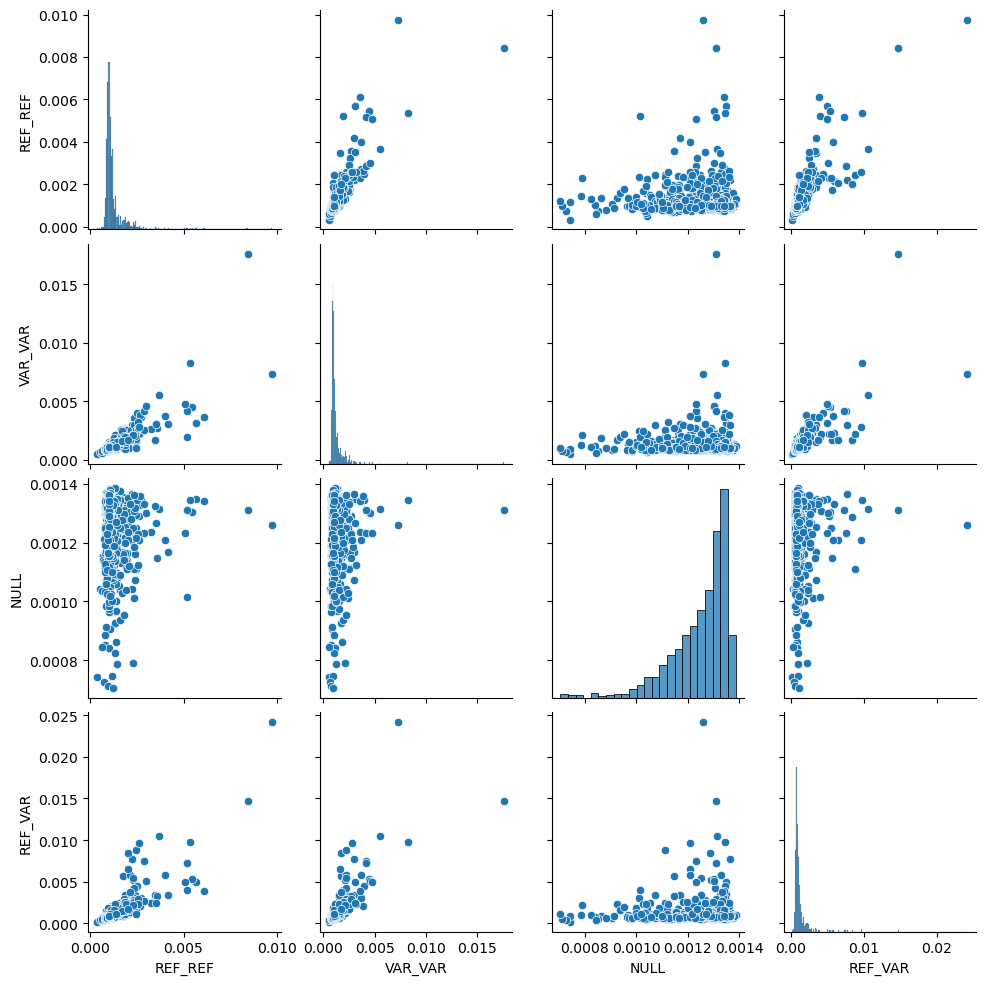

In [8]:
sns.pairplot(dna_summary.to_pandas())

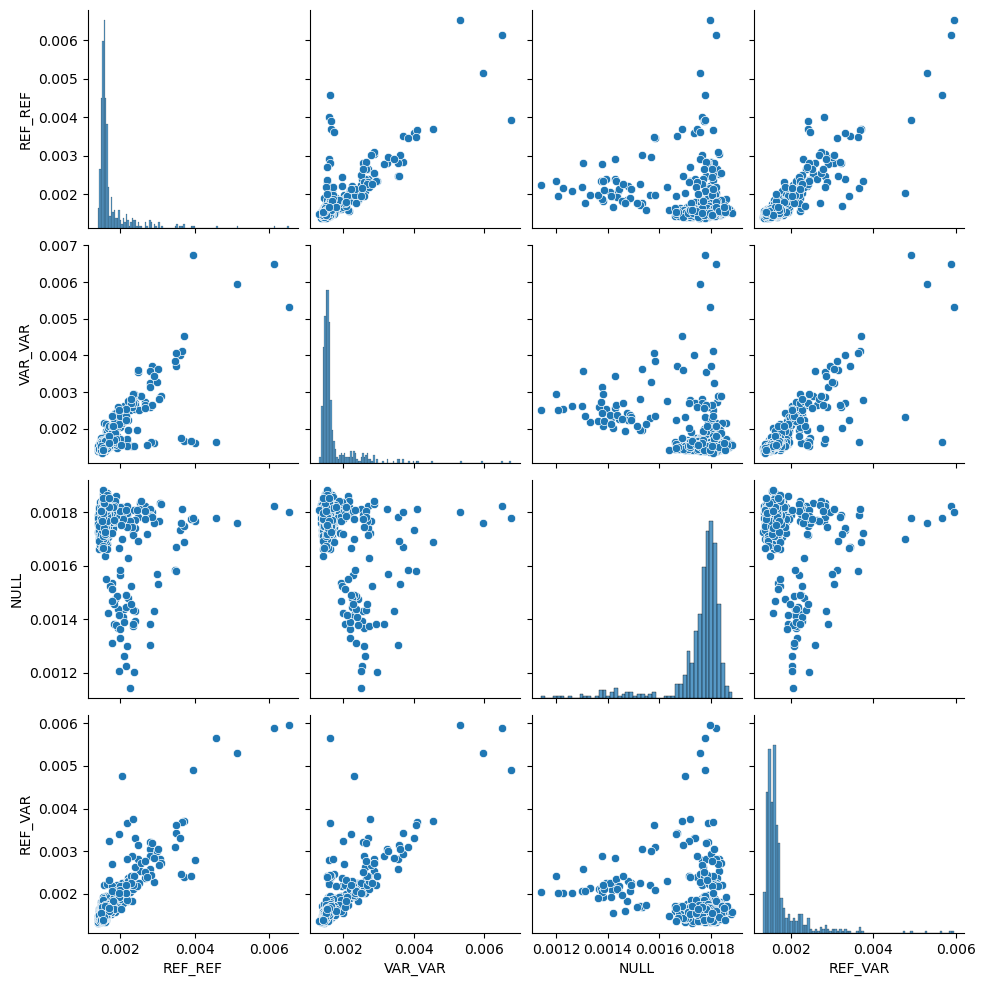

In [9]:
sns.pairplot(agp_summary.to_pandas())

In [ ]:
sns.pairplot(mito_summary.to_pandas())